In [1]:
from large_gcs.algorithms.gcs_star import GcsAstarReachability
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.graph.cost_constraint_factory import (
    shortcut_edge_cost_factory,
)
from large_gcs.algorithms.search_algorithm import SearchNode
from large_gcs.graph.graph import ShortestPathSolution
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
)
from large_gcs.graph.graph import Vertex
from large_gcs.algorithms.search_algorithm import AlgMetrics
from large_gcs.domination_checkers.sampling_domination_checker import SetSamples
from large_gcs.domination_checkers.reaches_new_containment import ReachesNewContainment
from large_gcs.domination_checkers.reaches_cheaper_containment import ReachesCheaperContainment

import numpy as np
from IPython.display import HTML
from pydrake.all import (
    Solve,
    SolverOptions,
    MathematicalProgram,
    CommonSolverOption,
    HPolyhedron,
)
import pypolycontain as pp

from large_gcs.geometry.polyhedron import Polyhedron
import ast
import logging

logging.basicConfig(level=logging.WARN)
logging.getLogger("large_gcs").setLevel(logging.DEBUG)
logging.getLogger(__name__).setLevel(logging.DEBUG)
logger = logging.getLogger(__name__)

/home/shaoyuan/Documents/Software/pypolycontain/pypolycontain/conversions.py:19: UserWarning: WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.
  warnings.warn("WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.")
/home/shaoyuan/Documents/Software/pypolycontain/pypolycontain/containment.py:16: UserWarning: You don't have CDD package installed. Unable to run cone ray generation.
  warnings.warn("You don't have CDD package installed. Unable to run cone ray generation.")


DEBUG:large_gcs.geometry.polyhedron:Decomposed inequality constraints: A = [[ 0.  1.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]], b = [-0.5 -3.5  2.5  5.5 -0.5 -3.5  2.5  5.5 -0.5 -3.5  2.5  5.5]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 58661.59it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 19645.45it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 10 body pairs...
100%|██████████| 10/10 [00:00<00:00, 172.50it/s]
DEBUG:large_gcs.geometry.polyhedron:Decomposed inequality constraints: A = [[ 0.  1.]
 

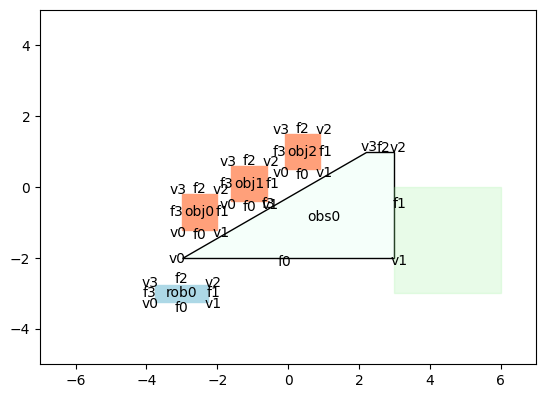

In [2]:
graph_file = ContactGraphGeneratorParams.inc_graph_file_path_from_name(
    "cg_stackpush_d2"
)
cg = IncrementalContactGraph.load_from_file(
    graph_file,
    should_incl_simul_mode_switches=False,
    should_add_const_edge_cost=True,
    should_add_gcs=True,
    should_use_l1_norm_vertex_cost=True,
)
cg.plot()

In [3]:
# Get problematic paths from logs

candidate_vertex_path = [
    "source",
    "('NC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f0-rob0_f2', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'NC|obj0_f0-rob0_f2', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('NC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'NC|obj0_f0-rob0_f2', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('NC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f3-obj0_v1', 'IC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f3-obj0_v1', 'IC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f3-obj0_v1', 'IC|obs0_f3-obj1_v1', 'IC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f3-obj0_v1', 'IC|obs0_f3-obj1_v1', 'NC|obs0_f2-obj2_f0', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f3-obj0_v1', 'NC|obs0_f2-obj1_f0', 'NC|obs0_f2-obj2_f0', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f2-obj0_f0', 'NC|obs0_f2-obj1_f0', 'NC|obs0_f2-obj2_f0', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f2-obj0_f0', 'IC|obs0_f2-obj1_f0', 'NC|obs0_f2-obj2_f0', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f2-obj0_f0', 'IC|obs0_f2-obj1_f0', 'NC|obs0_f1-obj2_f3', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
]
alt_vertex_path = [
    "source",
    "('NC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f0-rob0_f2', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'NC|obj0_f0-rob0_f2', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('NC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'NC|obj0_f0-rob0_f2', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('NC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f3-obj0_v1', 'IC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f3-obj0_v1', 'IC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f3-obj0_v1', 'IC|obs0_f3-obj1_v1', 'IC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f3-obj0_v1', 'IC|obs0_f3-obj1_v1', 'NC|obs0_f2-obj2_f0', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f3-obj0_v1', 'NC|obs0_f2-obj1_f0', 'NC|obs0_f2-obj2_f0', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f2-obj0_f0', 'NC|obs0_f2-obj1_f0', 'NC|obs0_f2-obj2_f0', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f2-obj0_f0', 'NC|obs0_f2-obj1_f0', 'NC|obs0_f1-obj2_f3', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
    "('IC|obs0_f2-obj0_f0', 'IC|obs0_f2-obj1_f0', 'NC|obs0_f1-obj2_f3', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')",
]

# Truncate paths for quicker testing
candidate_vertex_path = candidate_vertex_path[:2]
alt_vertex_path = alt_vertex_path[:2]

In [4]:
s = cg.vertices["source"].convex_set
s.center

array([-2.5, -0.7, -1.1,  0.1,  0.4,  1. , -3. , -3. ])

In [5]:
# Load these two paths into the graph

for v in candidate_vertex_path + alt_vertex_path:
    cg.generate_neighbors(v)

DEBUG:large_gcs.geometry.polyhedron:Decomposed inequality constraints: A = [[-1.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 0. -1.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]], b = [-1.7         3.5        -1.7         3.5        -0.         -0.44975021
 -0.44975021 -0.44975021 -0.44975021 -2.24999999 -2.24999999 -1.
 -1.         -1.         -1.         -0.74999999 -0.74999999 -1.
 -1.         -0.74999999 -0.74999999 -0.74999999 -0.74999999  6.5
  4.5         6.5         4.5         6.5         4.5         6.5
  4.5         6.5         4.5         6.5         4.5         6.5
  4.5         6.5         4.5         6.5         4.5         6.5
  4.5         6.5         4.5         6.5         4.5         6.24999999
  4.75000001  6.25000001  4.74999999  6.24999999  4.75000001  6.25000001
  4.74999999]
DEBUG:large_gcs.geometry.polyhedron:Decomposed equality constraints: C = [[ 0.  0.  1.  0.  0.  0.  0

In [6]:
n1 = SearchNode.from_vertex_path(candidate_vertex_path)
n2 = SearchNode.from_vertex_path(alt_vertex_path)

DEBUG:large_gcs.geometry.polyhedron:Polyhedron has equality constraints, creating null space polyhedron
DEBUG:large_gcs.geometry.polyhedron:
 A.shape: (52, 18), b.shape: (52,), C.shape: (8, 18), d.shape: (8,)
DEBUG:large_gcs.geometry.convex_set:Sampled 1 points from convex set


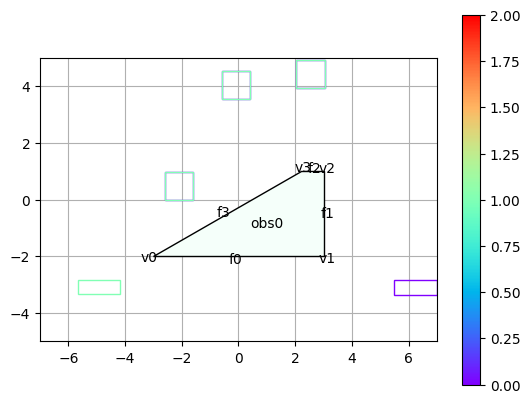

In [7]:
# Let's start by visualizing the terminal set.

cg.generate_and_plot_samples_in_set(n1.vertex_name, 1)

Now let's visualize the two paths

In [8]:
# cg.set_target(n1.vertex_name)
# sol = cg.solve_convex_restriction(n1.edge_path)
# cg.plot_current_solution()

In [9]:
# cg.set_target(n1.vertex_name)
# sol = cg.solve_convex_restriction(n2.edge_path)
# cg.plot_current_solution()

In [10]:
len(n1.vertex_path), len(n2.vertex_path)

(2, 2)

In [11]:
n1.vertex_name == n2.vertex_name

True

In [12]:
for i, (v1, v2) in enumerate(zip(n1.vertex_path, n2.vertex_path)):
    print(f"{i}: {v1 == v2}")

0: True
1: True


In [13]:
# So the only vertex that's different is that n1 has an additional vertex second to last.
# print(n1.vertex_path[-2])

Now let's try to use pypolycontain to check containment.

## Verifying Reaches Cheaper

In [14]:
domination_checker = ReachesCheaperContainment(cg)
domination_checker.set_alg_metrics(AlgMetrics())

In [15]:
prog = domination_checker.get_path_mathematical_program(n1)

In [16]:
bindings = prog.GetAllCosts()
for b in bindings:
    print(b.evaluator())
    print("num variables ", len(b.variables()))
    print("a ", b.evaluator().a())
    print("b", b.evaluator().b())
    print("decision variable indices", prog.FindDecisionVariableIndices(b.variables()))
    print(b.variables())

num variables  8
a  [1. 1. 1. 1. 1. 1. 1. 1.]
b 0.0
decision variable indices [26, 27, 28, 29, 30, 31, 32, 33]
[Variable('('NC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f0-rob0_f2', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'NC|obj0_f0-rob0_f2', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')_vertex_l1norm_cost(0)', Continuous)
 Variable('('NC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f0-rob0_f2', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'NC|obj0_f0-rob0_f2', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')_vertex_l1norm_cost(1)', Continuous)
 Variable('('NC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f0-rob0_f2', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'NC|obj0_f0-rob0_f2', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')_vertex_l1norm_cost(2)', Continuous)
 Variable('('NC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs

In [17]:
A_n, b_n = domination_checker.get_epigraph_matrices(n1)
A_n.shape, b_n.shape

((117, 35), (117,))

In [18]:
A_n[-1], b_n[-1]

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.]),
 -1.0)

In [19]:
A, b, C, d = domination_checker.get_path_A_b_C_d(n1)
A.shape, b.shape, C.shape, d.shape

DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:Total number of decision variables 35, sum of v_dims 26
DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:C.shape (8, 8)
DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:processing vertex constraint vertices[0]
DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:C.shape (8, 18)
DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:processing vertex constraint vertices[1]
DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:processing edge constraint edge[0]
DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:constraint <pydrake.solvers.LinearEqualityConstraint object at 0x71c4fd37a430>
DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:Adding linear equality constraint
DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:constraint <pydrake.solvers.LinearConstraint object a

((69, 35), (69,), (24, 35), (24,))

In [20]:
A[-1], b[-1]

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.]),
 -1.0)

In [22]:
assert np.allclose(A_n[-1], A[-1])
assert np.isclose(b_n[-1], b[-1])

## Verifying Reaches New

In [ ]:
domination_checker = ReachesNewContainment(cg)
domination_checker.set_alg_metrics(AlgMetrics())

In [ ]:
prog = domination_checker.get_path_constraint_mathematical_program(n1)

In [ ]:
prog = domination_checker.get_path_constraint_mathematical_program(n1)


In [ ]:
bindings = prog.GetAllConstraints()
for b in bindings:
    print(b.evaluator())
    print("num variables ", len(b.variables()))
    print("dense A shape ", b.evaluator().GetDenseA().shape)
    print("lower bound shape", b.evaluator().lower_bound().shape)
    print("upper bound shape", b.evaluator().upper_bound().shape)
    print(
        "lower bound == upper bound",
        np.allclose(b.evaluator().lower_bound(), b.evaluator().upper_bound()),
    )
    print("decision variable indices", prog.FindDecisionVariableIndices(b.variables()))
    print("A ", b.evaluator().GetDenseA())
    print("lower bound ", b.evaluator().lower_bound())
    print("upper bound ", b.evaluator().upper_bound())
    print(b.variables())

In [ ]:
prog.decision_variables()

In [ ]:
prog.decision_variables().shape

In [ ]:
# set_1 = cg.vertices[n1.vertex_name].convex_set
# set_1.A.shape, set_1.b.shape, set_1.C.shape, set_1.d.shape, set_1.H.shape, set_1.h.shape

In [ ]:
# set_1_A_n, set_1_b_n, set_1_C_n, set_1_d_n= Polyhedron.get_separated_inequality_equality_constraints(set_1.H, set_1.h)
# set_1_A_n.shape, set_1_b_n.shape, set_1_C_n.shape, set_1_d_n.shape

In [ ]:
# assert np.allclose(set_1_A_n, set_1.A)
# assert np.allclose(set_1_b_n, set_1.b)
# assert np.allclose(set_1_C_n, set_1.C)
# assert np.allclose(set_1_d_n, set_1.d)

In [ ]:
A, b, C, d = domination_checker.get_path_A_b_C_d(n1)
A.shape, b.shape, C.shape, d.shape


In [ ]:
H_n, h_n = domination_checker.get_feasibility_matrices_via_prog(n1)
T_n = domination_checker.get_H_transformation(
    node=n1,
    A=H_n,
)

A_alt, b_alt = domination_checker.get_feasibility_matrices_via_prog(n2)
T_alt = domination_checker.get_H_transformation(
    node=n2,
    A=A_alt,
)

In [ ]:
T_n.shape, T_alt.shape

In [ ]:
H_n.shape, h_n.shape, A_alt.shape, b_alt.shape

In [ ]:
A_n, b_n, C_n, d_n = Polyhedron.get_separated_inequality_equality_constraints(H_n, h_n)
A_n.shape, b_n.shape, C_n.shape, d_n.shape

In [ ]:
assert np.allclose(A_n, A)
assert np.allclose(b_n, b)

# Check whether A_n and A are effectively the same
X = HPolyhedron(A_n, b_n)
Y = HPolyhedron(A, b)
assert not X.IsEmpty()
assert not Y.IsEmpty()
assert Y.ContainedIn(X, tol=1e-6)
assert X.ContainedIn(Y, tol=1e-6)

# Check whether C_n and C are effectively the same
X = HPolyhedron(np.vstack([C_n, -C_n]), np.hstack([d_n, -d_n]))
Y = HPolyhedron(np.vstack([C, -C]), np.hstack([d, -d]))
assert not X.IsEmpty()
assert not Y.IsEmpty()
assert Y.ContainedIn(X)
assert X.ContainedIn(Y)
# assert(np.allclose(C_n, C))
# assert(np.allclose(d_n, d))

In [ ]:
AH_X = domination_checker._create_path_AH_polytope(n1)
AH_Y = domination_checker._create_path_AH_polytope(n2)

In [ ]:
prog = MathematicalProgram()
pp.subset(prog, AH_X, AH_Y, -1)

In [ ]:
domination_checker._solve_containment_prog(prog)

In [ ]:
res = domination_checker.is_dominated(n1, [n2])

In [ ]:
res